## Traffic Sign Recognition Classifier with TensorFlow2.0


## Step 0: Load The Data

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals 

# import packages 
import pickle 
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import os 
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.regularizers import l2
tf.keras.backend.set_floatx('float32')


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2149739731058156952, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5577864491839609741
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2890958180798834748
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12842073670820264612
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/git_repos/traffic_sign_classifier'

/content/drive/My Drive/git_repos/traffic_sign_classifier


In [4]:
train_file = 'drive/My Drive/git_repos/traffic_sign_classifier/data/train.p'
train_file = 'data/train.p'
valid_file = 'drive/My Drive/git_repos/traffic_sign_classifier/data/valid.p'
valid_file = 'data/valid.p'
test_file = 'drive/My Drive/git_repos/traffic_sign_classifier/data/test.p'
test_file = 'data/test.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(valid_file, mode='rb') as f:
    valid = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


## Step1 : Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:
- `features` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `labels` is a 1D array containing the label/class id of the traffic sign. The file `signames.csv` contains id -> name mappings for each id. 
- `sizes` is a list containing tuples, (width, height) representing the original width and height the image.
- `coords` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THSE IMAGES**


In [6]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = (max(y_train)+1).astype(np.int) 

print('Number of train examples :', n_train)
print('Number of validation examples :', n_valid)
print('Number of test examples :', n_test)
print('Image data shape : ', image_shape)
print('Number of Classes : ', n_classes)

Number of train examples : 34799
Number of validation examples : 4410
Number of test examples : 12630
Image data shape :  (32, 32, 3)
Number of Classes :  43


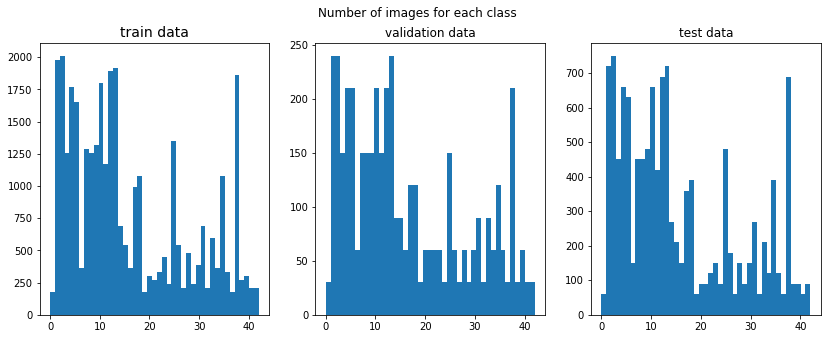

In [7]:
%matplotlib inline 
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.subplots_adjust(hspace=2)
fig.suptitle('Number of images for each class')
axes[0].hist(y_train, n_classes, (0, n_classes-1))
axes[0].set_title('train data', fontsize=14)
axes[1].hist(y_valid, n_classes, (0, n_classes-1))
axes[1].set_title('validation data')
axes[2].hist(y_test, n_classes, (0, n_classes-1))
axes[2].set_title('test data')
plt.show()

## Display images of each class 

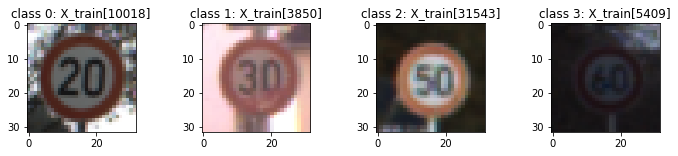

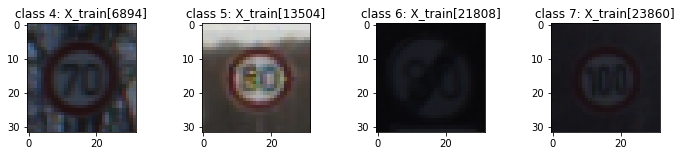

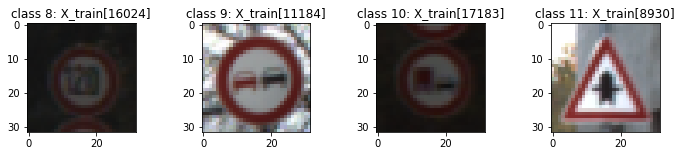

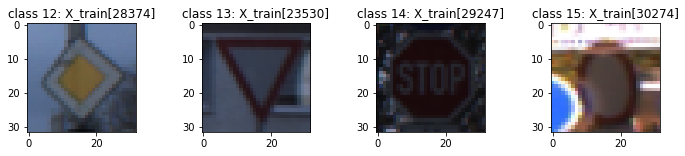

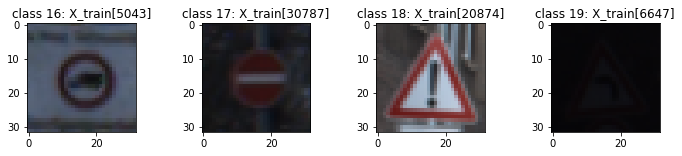

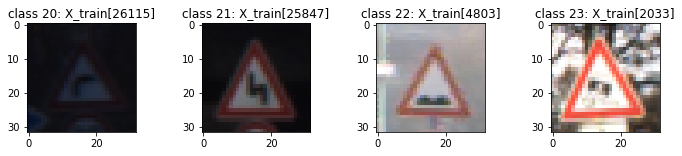

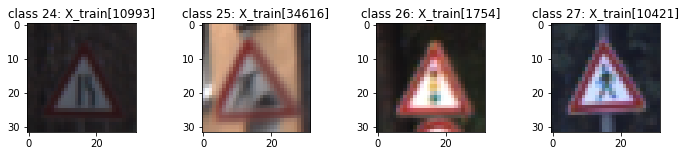

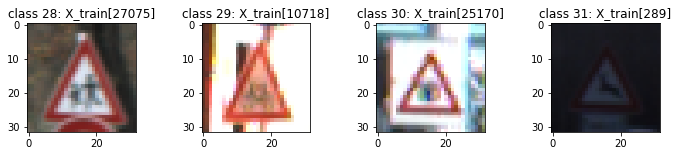

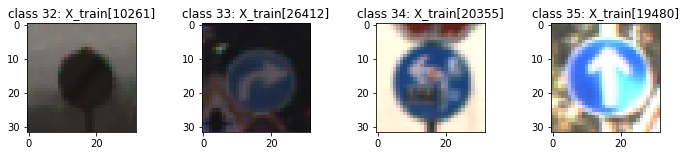

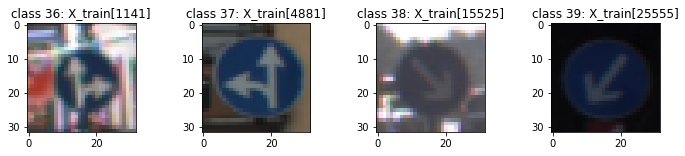

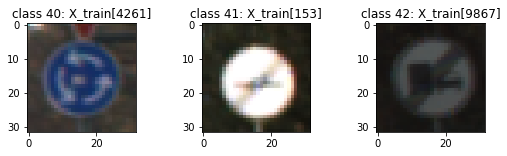

In [8]:
import random

for i in range(0, n_classes, 4):
    plt.figure(figsize=(12, 2))
    for j in range(4):
        indexes = np.where(y_train == i+j)[0]
        if len(indexes) == 0:
            break 
        index = indexes[random.randint(0, len(indexes)-1)]
        title = 'class {}: X_train[{}]'.format(i+j, index)
        img = X_train[index]
        plt.subplot(1, 4, j+1) 
        plt.imshow(img) 
        plt.title(title) 
    plt.show()

## Make the histogram of lightness values equal 


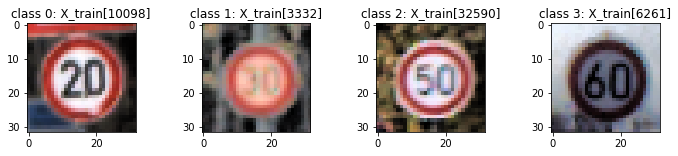

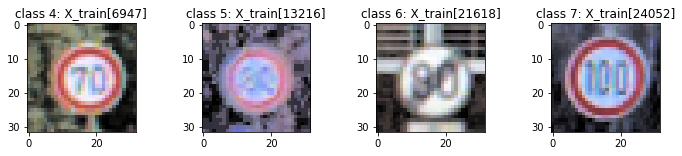

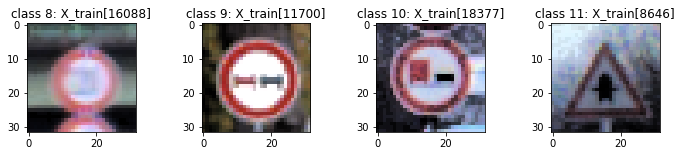

In [9]:
for i in range(0, 12, 4):
    plt.figure(figsize=(12, 2))
    for j in range(4):
        indexes = np.where(y_train == i+j)[0]
        if len(indexes) == 0:
            break 
        index = indexes[random.randint(0, len(indexes)-1)]
        title = 'class {}: X_train[{}]'.format(i+j, index)
        img = X_train[index]
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_img[: , :, 2] = cv2.equalizeHist(hsv_img[:,:,2])
        plt.subplot(1, 4, j+1) 
        plt.imshow(cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB))
        plt.title(title) 
    plt.show()

## Preprocessing and data augmentation 
class with less than 900 images 
- Enlarge and cut the center 
- Increase the image of the class with few images 

In [0]:
# Equalize lightness histgram each images 
def equalizeLightness(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2]) 
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB) 
    return rgb_img 

In [0]:
preprocessed_X_train = np.array([equalizeLightness(img) for img in X_train[:]])
preprocessed_X_valid = np.array([equalizeLightness(img) for img in X_valid[:]])
preprocessed_X_test = np.array([equalizeLightness(img) for img in X_test[:]])

# mean/std preprocessing
mean_X = np.mean(preprocessed_X_train, axis=0)
std_X = np.mean(preprocessed_X_train, axis=0)
preprocessed_X_train = (preprocessed_X_train - mean_X)/std_X
preprocessed_X_valid = (preprocessed_X_valid - mean_X)/std_X
preprocessed_X_test = (preprocessed_X_test - mean_X) /std_X

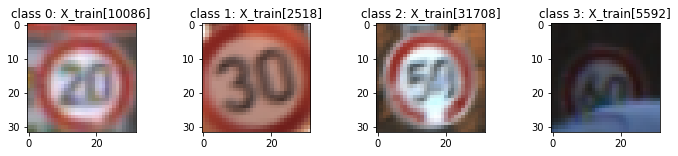

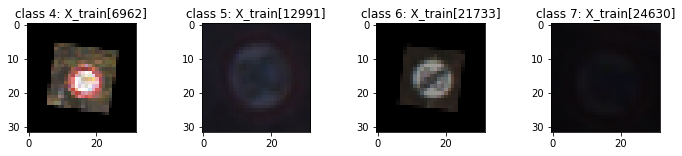

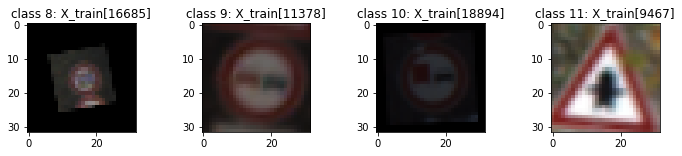

In [12]:
def rotateImage(img, angle=3, scale=1):
    cols, rows = img.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
    dst = cv2.warpAffine(img, M, (cols, rows)) 
    return dst 

for i in range(0, 12, 4):
    plt.figure(figsize=(12, 2))
    for j in range(4):
        indexes = np.where(y_train == i+j)[0]
        if len(indexes) == 0:
            break
        index = indexes[random.randint(0, len(indexes)-1)]
        title = 'class {}: X_train[{}]'.format(i+j, index)
        img = X_train[index]
        # rotate image and re-scaling image
        scale = 1.0 + random.uniform(-0.5, 0.5)
        angle = random.uniform(-15, 15)
        res = rotateImage(img, angle, scale)
        res = res.astype(np.uint8)
        plt.subplot(1, 4, j+1)
        plt.imshow(res)
        plt.title(title)
    plt.show()

In [13]:
# data augmentation for each class which has few images. 
print('X_train.shape={}'.format(X_train.shape))
print() 

X_train_sub = preprocessed_X_train.copy()
y_train_sub = y_train.copy() 


for class_index in range(n_classes):
    image_index = np.where(y_train == class_index)[0]
    
    if len(image_index)< 900:
        augmentation_img = np.zeros((len(image_index), 32, 32, 3))
        augmentation_img2 = np.zeros((len(image_index), 32, 32, 3))
        y_augmentation = np.zeros((len(image_index)))
        y_augmentation2 = np.zeros((len(image_index)))
        print('class: {}, num of images in class : {}'.format(class_index, len(image_index)))
        
        for i, ind in enumerate(image_index):
            img = preprocessed_X_train[ind]
            scale = 1.0 + random.uniform(-0.5, 0.5)
            angle = random.uniform(-15, 15) 
            resize_img = rotateImage(img, angle, scale) 
            resize_img = resize_img.astype(np.uint8)
            augmentation_img[i] = resize_img 
            y_augmentation[i] = class_index 
            resize_img = rotateImage(img, -angle, scale)
            augmentation_img2[i] = resize_img 
            y_augmentation2[i] = class_index
        
        X_train_sub = np.vstack((X_train_sub, augmentation_img, augmentation_img2))
        y_train_sub = np.hstack((y_train_sub, y_augmentation, y_augmentation2))


X_train.shape=(34799, 32, 32, 3)

class: 0, num of images in class : 180
class: 6, num of images in class : 360
class: 14, num of images in class : 690
class: 15, num of images in class : 540
class: 16, num of images in class : 360
class: 19, num of images in class : 180
class: 20, num of images in class : 300
class: 21, num of images in class : 270
class: 22, num of images in class : 330
class: 23, num of images in class : 450
class: 24, num of images in class : 240
class: 26, num of images in class : 540
class: 27, num of images in class : 210
class: 28, num of images in class : 480
class: 29, num of images in class : 240
class: 30, num of images in class : 390
class: 31, num of images in class : 690
class: 32, num of images in class : 210
class: 33, num of images in class : 599
class: 34, num of images in class : 360
class: 36, num of images in class : 330
class: 37, num of images in class : 180
class: 39, num of images in class : 270
class: 40, num of images in class : 300
class: 4

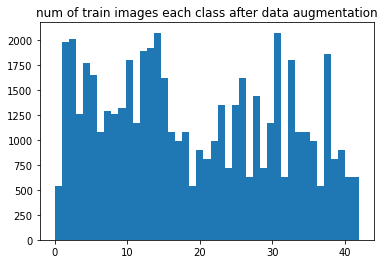

In [14]:
plt.hist(y_train_sub, n_classes, (0, n_classes-1))
plt.title('num of train images each class after data augmentation')
plt.show()

## shuffle dataset and バッチ化

In [15]:
X_train = X_train_sub 
y_train = y_train_sub 

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


train_ds = tf.data.Dataset.from_tensor_slices(
        (X_train, y_train)).shuffle(10000).batch(128)
valid_ds = tf.data.Dataset.from_tensor_slices(
        (preprocessed_X_valid, y_valid)).shuffle(10000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(
        (preprocessed_X_test, y_test)).shuffle(10000).batch(64) 


(53037, 32, 32, 3) (53037,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


## Model Architecture 

In [0]:
class WideResnetIdentityBlock(tf.keras.Model):
    """
    Resnet Block for wideresnet
    For more detail, see the paper.
    """
    def __init__(self, filter, k, rate=0.2):
        super(WideResnetIdentityBlock, self).__init__(name='')
        filter = filter * k
        
        self.bn1 = BatchNormalization()
        self.conv1 = Conv2D(filter, (3, 3), padding='same', kernel_regularizer=l2(0.0005))
        
        self.dp = Dropout(rate=0.2)
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(filter, (3, 3), padding='same', kernel_regularizer=l2(0.0005))
        
    def call(self, input_tensor, training=False):
        x = self.bn1(input_tensor, training=training)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        
        x = self.dp(x, training=training)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        x += input_tensor
        return x

class WideResNet28(Model):
    def __init__(self, k):
        super(WideResNet28, self).__init__()
        self._layers = [
            # 32x32x16
            Conv2D(16, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.0005)),
            Conv2D(16*k, (1, 1), strides=(1, 1), padding='same', kernel_regularizer=l2(0.0005)),
            # 32x32x160
            [WideResnetIdentityBlock(16, k) for _ in range(2)],
            Conv2D(32*k, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.0005)),
            # 16x16x320
            [WideResnetIdentityBlock(32, k) for _ in range(2)],
            Conv2D(64*k, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.0005)),
            # 8x8x640
            [WideResnetIdentityBlock(64, k) for _ in range(2)],
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(n_classes, activation='softmax')]
            
    
    def call(self, x, training=False):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x, training)
            else:
                x = layer(x)
        return x

    

#  モデルのインスタンスを作製
model = WideResNet28(k=1) 

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.3, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam()

In [0]:
train_loss = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name="validation_loss")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [0]:
@tf.function()
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)
    return loss

@tf.function()
def valid_step(images, labels):
    predictions = model(images, False)
    v_loss = loss_object(labels, predictions) 
    
    valid_loss(v_loss)
    valid_accuracy(labels, predictions)
  
@tf.function()
def test_step(images, labels):
  predictions = model(images, False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
    
def lr_scheduler(epoch):
    if epoch < 60:
        return 0.03
    elif 60 <= epoch < 120:
        return 0.03 * 0.2 
    else:
        return 0.03 * 0.2 * 0.2

In [20]:
EPOCHS = 10
t_losses = []
v_losses = []

for epoch in range(EPOCHS):
    lr = lr_scheduler(epoch)
    optimizer.lr = lr
    for i, (images, labels) in enumerate(train_ds):
        loss = train_step(images, labels)
        t_losses.append(loss)
        
    for images, labels in valid_ds:
        valid_step(images, labels) 
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(epoch+1,
                                            train_loss.result(),
                                            train_accuracy.result()*100,
                                            valid_loss.result(),
                                            valid_accuracy.result()*100))
    
    v_losses.append(valid_loss.result())
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
  




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: ignored

In [25]:
model.save('resnet', save_format='tf')
# new_model = tf.keras.models.load_model('.')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet/assets


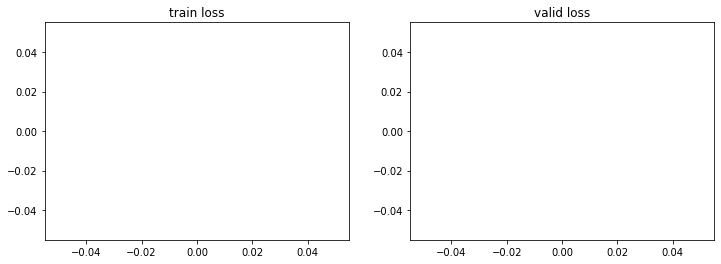

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(len(t_losses)), t_losses)
plt.title('train loss')
plt.subplot(122)
plt.plot(range(len(v_losses)), v_losses)
plt.title('valid loss')
plt.show()

In [34]:
for images, labels in test_ds:
    test_step(images, labels) 
test_loss.result(), test_accuracy.result()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.36713046>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.897308>)

number of miss-classifier images: 420


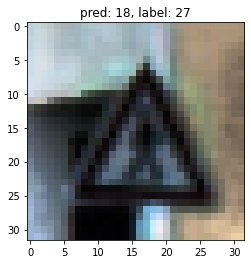

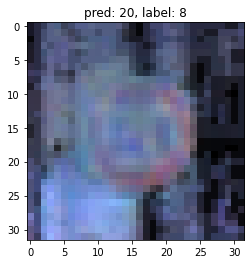

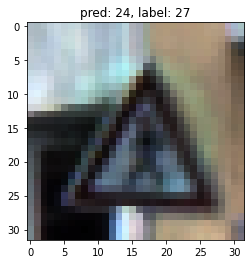

In [23]:
model = tf.keras.models.load_model('resnet')
def getMissClassifier():
  '''
  Return the misidentified image in the model.
  '''
  # predict => model's prediction 
  # true => actually class 
  miss_img = {'img':[], 'predict': [], 'true': []}

  for i, (images, labels) in enumerate(valid_ds):
    predict = model(images, False)
    predict = predict.numpy().argmax(axis=1)

    miss_index = np.where(predict != labels)
    for i in miss_index[0]:
      miss_img['img'].append(images[i])
      miss_img['predict'].append(predict[i])
      miss_img['true'].append(labels[i])
  print('number of miss-classifier images: {}'.format(len(miss_img['img'])))
  return miss_img
  
miss = getMissClassifier()
visualize_ind = random.sample(range(len(miss['img'])), k=3)
for ind in visualize_ind:
  img, pred_name, label_name = miss['img'][ind].numpy(), miss['predict'][ind], miss['true'][ind]
    
  plt.imshow((img - np.min(img))/(np.max(img) - np.min(img)))
  plt.title('pred: {}, label: {}'.format(miss['predict'][ind], miss['true'][ind]))
  plt.show()

## Load and Output the Images

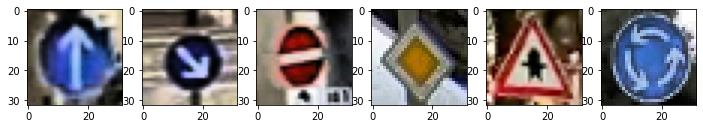

In [24]:
import matplotlib.image as mpimg 
test_img = {'label': [], 'image':[]}
plt.figure(figsize=(12, 8))

fnames = os.listdir('test_images')
fnames.sort()
for i, fname in enumerate(fnames, start=1):
  img = mpimg.imread(os.path.join('test_images', fname))
  img = cv2.resize(img, (32, 32))
  # preprocessing 
  img = equalizeLightness(img) 
  plt.subplot(1, 6, i) 
  plt.imshow(img) 
  img = (img - mean_X) / std_X
  test_img['image'].append(img) 
plt.show()

In [0]:
test_img['label'].append(35) # Ahead only
test_img['label'].append(38) # Keep right
test_img['label'].append(17) # No entry
test_img['label'].append(12) # Priority road 
test_img['label'].append(11) # right of way 
test_img['label'].append(40) # roundabout

In [41]:
import pandas 
df = pandas.read_csv('./signnames.csv')
df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [82]:
num_test_imgs = len(test_img['image']) 
test_img['predict'] = []
correct = 0

for i in range(num_test_imgs):
  img = test_img['image'][i].reshape((-1, 32, 32, 3))
  predict = model(img, False).numpy()
  predict_label = predict.argmax(axis=1)
  test_img['predict'].append(predict[0])
  print('correct label:{}, predict label: {}'.format(test_img['label'][i], predict_label[0]))
  if test_img['label'][i] == predict_label[0]:
    correct += 1

print()
print('accuracy => {:.2f}'.format(correct / num_test_imgs))

correct label:35, predict label: 35
correct label:38, predict label: 38
correct label:17, predict label: 17
correct label:12, predict label: 12
correct label:11, predict label: 11
correct label:40, predict label: 33

accuracy => 0.83


[35 36  3 37 33]
[38 12 40 31 25]
[17 39 14 12 13]
[12 22 13 25 26]
[11 27 24 30 28]
[33 40 35 34 39]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


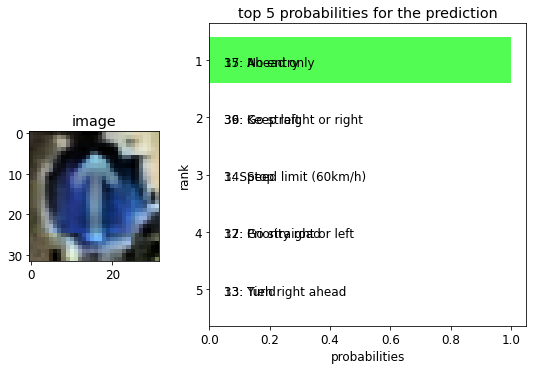

In [130]:
import matplotlib.animation as animation
from IPython.display import HTML
test_img['top_5'] = []
for i in range(num_test_imgs):
  img = test_img['image'][i].reshape((-1, 32, 32, 3))
  predict = model(img, False).numpy()[0]
  top_5_ind = np.array(sorted(range(len(predict)), key=lambda i: -predict[i]))[:5]
  print(top_5_ind)
  test_img['top_5'].append(top_5_ind)

plt.rcParams['font.size'] = 12 

fig = plt.figure(figsize=(8, 6))

img = test_img['image'][0]
img = (img - np.min(img)) / (np.max(img) - np.min(img))
top_5 = test_img['top_5'][0]
predict = test_img['predict'][0]

hist_x = [5, 4, 3, 2, 1]
num_disp = 3 
frame = 30


def update(i):
  ind = i  // frame 
  i = i % frame 
  
  img = test_img['image'][ind]
  img = (img - np.min(img)) / (np.max(img) - np.min(img))
  top_5 = test_img['top_5'][ind] 
  predict = test_img['predict'][ind]

  if i != 0:
    plt.cla()
  plt.axes([0.0, 0.35, 0.3, 0.3])
  plt.imshow(img)
  plt.title('image')

  plt.axes([0.35, 0.2, 0.55, 0.7])
  plt.title('top 5 probabilities for the prediction')
  # plt.barh(hist_x, predict[top_5]/frame * (i+1), color="#16FC167D")
  plt.barh(hist_x, predict[top_5], color='#16FC167D')
  plt.yticks(hist_x, [1,2,3,4,5])
  plt.xlabel('probabilities')
  plt.ylabel('rank')
  plt.xlim([0, 1.05])
  for pos_x, label_ind in zip(hist_x, top_5):
      label = df.loc[label_ind, 'SignName']
      text = str(label_ind) + ': ' + label
      plt.annotate(text, xy=(0.05, pos_x-0.1))
  plt.tight_layout()
  

ani = animation.FuncAnimation(fig, update, frame*num_disp, interval=10)
w = animation.PillowWriter(fps=frame)
ani.save('sample.gif', writer=w)

In [0]:
b